# Titanic Analysis Cookbook version

Cyrille Rossantの「IPythonデータサイエンスクックブック」に掲載されているTitanicのデータセット演習。<br>
以下の3つの文献を参考にしながら、理解を進めた。

## Reference

[1] Cyrille Rossant, IPython Cookbook, "8.2. Predicting who will survive on the Titanic with logistic regression"  
http://ipython-books.github.io/  
[2] Udacity 359
Project 2

## データセットの特徴
- データサイズ = (891, 12） 

- PassengerId: 搭乗者ID
- Survived: 事故での生死の結果(0 = No; 1 = Yes)
- Pclass: 乗客の船室クラス(1 = 1st; 2 = 2nd; 3 = 3rd)
- Name: 氏名
- Sex: 性別
- Age: 年齢
- SibSp: 同伴している親戚の数
- Parch: 同伴している親または子の数
- Ticket: チケット番号
- Fare: 乗船料金
- Cabin: 客室番号、ほとんどがNaN
- Embarked: 乗船した港(C = Cherbourg; Q = Queenstown; S = Southampton)
       
## Cookbookバージョンの特徴
1. データセットの提供元である[Kaggle](http://www.kaggle.com/c/titanic-gettingStarted)のサイトにあるとおり、trainとtestの2つのファイルを読み込んでいる。<br>しかしtrainのみを使用しており、testは使っていない。
2. 特徴量（説明変数）は3つ（Pclass, Sex, Age）、ラベル（目的変数）は1つ（Survived）。
3. 機械学習モデルにデータを入力するため、AgeのNAデータ177件を削って、トレーニングデータが714件に減っている。

## 演習で加えた工夫
1. train_data, test_dateの区分をsklearnの関数で行い、ロジスティック回帰以外のメソッドを使う。
2. scatter-matrixを使って、データの分布を俯瞰する。

You need to download the Titanic dataset on the book's website (https://ipython-books.github.io).

Here, we use this example to introduce logistic regression, a basic classifier. We also show how to perform a grid search with cross-validation.
We import the standard libraries.

In [113]:
# PyData系の標準的なライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearnのライブラリ
import sklearn
import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.grid_search as gs
%matplotlib inline

In [114]:
# trainセットとtestセットのファイルの読み込み
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv('data/titanic_test.csv')

## trainセットの概観

In [115]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [116]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Ageのcountが７１４とほかの項目より少ない。差はNull値（np.nan）の数に相当する。  
scikit-learnの機械学習モデルに、Null値を入力することはできないので、<br>
データを削除するか、平均値で埋めるなどの処理が必要となる。

## testセットの概観

In [117]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [118]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


testセットでもAgeにNullがあることが確認できる。<br>
しかしCookbookではtestセットは利用していないので、上記のデータ読み込みは省略可能。


## データ分析のためのDataFrameを作成する
trainセットから3つの特徴量（Pclass, Sex, Age）とラベル（Survived）を抽出する。

In [119]:
train[train.columns[[2,4,5,1]]].head()

,Pclass,Sex,Age,Survived
0,3,male,22,0
1,1,female,38,1
2,3,female,26,1
3,1,female,35,1
4,3,male,35,0


In [120]:
# Ageには177件のNaNデータが含まれている
train.Age.isnull().sum()

177

scikit-learnの分類器でデータを扱うことができるように、'Sex'の項目をバイナリーデータに変換し、NaNデータを取り除く。

In [121]:
# オリジナルのデータセットを直接に編集せず、必要な部分のみコピー
data = train[['Sex', 'Age', 'Pclass', 'Survived']].copy()
# 女性=1, 男性=0としてdata['Sex']の特徴量を入れ替える
data['Sex'] = data['Sex'] == 'female'
# dataからNAを取り除く
data = data.dropna()
# dataが891件から714件に減る
print(data.shape)
data.head()

(714, 4)


,Sex,Age,Pclass,Survived
0,False,22,3,0
1,True,38,1,1
2,True,26,3,1
3,True,35,1,1
4,False,35,3,0


dataをscikit-learnで扱うために、DataFrame形式からnump.array形式に変換する。
機械学習の分野では慣習的に、特徴量のマトリクスをX、ラベルのベクトルをyで表示する。

In [122]:
# 'Survive'が目的変数なのでyに代入。そのほかの特徴量をまとめてXに入れる。
data_np = data.astype(np.int32).values
X = data_np[:,:-1]
y = data_np[:,-1]

性別の違いによる乗客の生存の結果を見る。

In [123]:
# We define a few boolean vectors.
female = X[:,0] == 1
survived = y == 1
# This vector contains the age of the passengers.
age = X[:,1]
# We compute a few histograms.
bins_ = np.arange(0, 81, 5)
bins_

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

In [124]:
# 'S'はSurvived'（生）, 'D'は'Dead'（死）を意味する
S = {'male': np.histogram(age[survived & ~female], 
                          bins=bins_)[0],
     'female': np.histogram(age[survived & female], 
                            bins=bins_)[0]}
D = {'male': np.histogram(age[~survived & ~female], 
                          bins=bins_)[0],
     'female': np.histogram(age[~survived & female], 
                            bins=bins_)[0]}

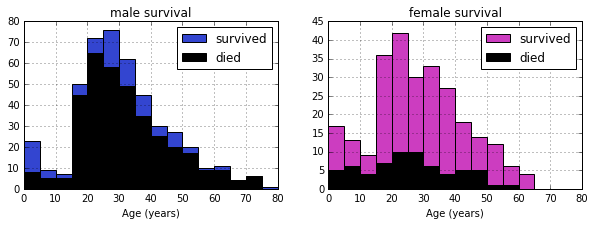

In [125]:
# ヒストグラムを表示する
# この辺りのコードの流れがエレガントなので、ぜひ学びたい
bins = bins_[:-1]
plt.figure(figsize=(10,3));
for i, sex, color in zip((0, 1),
                         ('male', 'female'),
                         ('#3345d0', '#cc3dc0')):
    plt.subplot(121 + i);
    plt.bar(bins, S[sex], bottom=D[sex], color=color,
            width=5, label='survived');
    plt.bar(bins, D[sex], color='k', width=5, label='died');
    plt.xlim(0, 80);
    plt.grid(None);
    plt.title(sex + " survival");
    plt.xlabel("Age (years)");
    plt.legend();

6. Let's try to train a `LogisticRegression` classifier. We first need to create a train and a test dataset.

In [126]:
# データセットを分割する。test_size = 0.05
# データセットの分け方が変わらないように、random_stateを決めておく
(X_train, X_test,  y_train, y_test) = cv.train_test_split(X, y, test_size=.05, random_state=0)

In [127]:
# 分類器インスタンスを作成する。
# "logreg"の代わりに、"clf"という変数名を使用した。
clf = lm.LogisticRegression()

7. Let's train the model and get the predicted values on the test set.

In [128]:
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
y_predicted.size

36

The following figure shows the actual and predicted results.

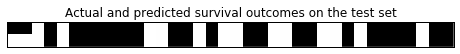

In [129]:
plt.figure(figsize=(8, 3))
plt.imshow(np.vstack((y_test, y_predicted)),
           interpolation='none', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(("Actual and predicted survival outcomes on the test set"))

8. To get an estimation of the performance of the model, we can use the `cross_val_score` that computes the cross-validation score. This function uses by default a 3-fold stratified cross-validation procedure, but this can be changed with the `cv` keyword argument.

In [130]:
cv.cross_val_score(clf, X, y)

array([ 0.78661088,  0.78991597,  0.78059072])

This function returns, for each pair of train and test set, a prediction score.

9. The `LogisticRegression` class accepts a `C` hyperparameter as argument. This parameter quantifies the regularization strength. To find a good value, we can perform a grid search with the `GridSearchCV` class. It takes as input an estimator, and a dictionary of parameter values. This new estimator uses cross-validation to select the best parameter.

In [131]:
grid = gs.GridSearchCV(clf, {'C': np.logspace(-5, 5, 200)}, n_jobs=4)
grid.fit(X_train, y_train)
grid.best_params_

{'C': 0.058727866131894832}

Here is the performance of the best estimator.

In [132]:
cv.cross_val_score(grid.best_estimator_, X, y)

array([ 0.77405858,  0.79411765,  0.78481013])

In [133]:
grid.best_estimator_

LogisticRegression(C=0.058727866131894832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

## ほかの分類器との比較
scoreだけで評価してよいのか不明。過学習していないかを確認しないのか？

In [134]:
# We instanciate the classifier.
import sklearn.tree

clf = sklearn.tree.DecisionTreeClassifier()
score = sklearn.cross_validation.cross_val_score(clf, X, y )
print(score)

[ 0.77405858  0.82352941  0.8185654 ]


In [135]:
import sklearn.ensemble

clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score(clf, X, y )
print(score)

[ 0.74895397  0.82352941  0.78481013]


ベストの予測でも78%程度の的中率になっている。<br>
logregよりもRandomForrestなどの方が適している可能性がある。

## まとめ
Cookbookのコードフォローを行った。
次の課題として、PCAを行って、次元削減することなどを検討したい。